In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from scipy.stats import boxcox, skew
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder , PowerTransformer, MultiLabelBinarizer , MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

%load_ext autoreload
%autoreload 2

import plotly.io as pio
pio.renderers.default = 'iframe'

In [2]:
## Local Utils File
from utils.eda import *
from utils.road_tax import *
from utils.kanhon_utils import *
from utils.melissa_imputers import *
from utils.melissa_utils import *
from utils.Bhushan_utils import *
from utils.lta_omv_scraper import *
from utils.models import Regression
from utils.regression_evaluation import *

## Load Dataset

In [3]:
test_df = pd.read_csv(r"./dataset/test.csv")
test_df['model'] = test_df['model'].apply(lambda x:x.replace('(', ''))
test_df['reg_date_dt'] = test_df['reg_date'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))
test_df['reg_date_year'] = test_df['reg_date_dt'].apply(lambda x:x.year)
test_df['reg_date_month'] = test_df['reg_date_dt'].apply(lambda x:x.month)

orig_df = pd.read_csv(r"./dataset/train.csv")

# clean model
orig_df['model'] = orig_df['model'].apply(lambda x:x.replace('(', ''))
orig_df['reg_date_dt'] = orig_df['reg_date'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))
orig_df['reg_date_year'] = orig_df['reg_date_dt'].apply(lambda x:x.year)
orig_df['reg_date_month'] = orig_df['reg_date_dt'].apply(lambda x:x.month)


## Outlier Removal

In [4]:
# ## Sanity Check
# train_pkl_dir_path = "./dataset/proc_scraped_new_car_info.pkl"
# train_scraped = pd.read_pickle(train_pkl_dir_path)

# mapping = {
#     "suv": 'SUV',
#      'mpv': 'MPV',
#     "luxury sedan" : 'Luxury Sedan',
#     "mid-sized sedan": "Sedan",
#      'sports car' : 'Sports',
#      'truck' : 'Commercial',
#      'hatchback': 'Hatchback',
#      'stationwagon' : 'Stationwagon',
#      'bus/mini bus':'Commercial',
#      'van':'Commercial',
#      'others':'Commercial'
# }
# # feature = "Engine Capacity"
# # feature = "Power"
# feature= "Kerb Weight"

# ref = train_scraped.groupby(["Vehicle Type"])[feature].agg(["min","max"]).reset_index()
# train_ref = orig_df.groupby(["type_of_vehicle"])["curb_weight"].agg(["min","max"]).reset_index()
# i=0
# for elem in orig_df["type_of_vehicle"].unique():
#     _, min_val, max_val = ref[ref["Vehicle Type"] == mapping[elem]].iloc[0]
#     _, min_train_val, max_train_val = train_ref[train_ref["type_of_vehicle"] ==elem].iloc[0]
#     if (min_train_val < min_val) & (max_train_val > max_val):
#         print("min | max :: " ,elem)
#         i+=1
#     elif (min_train_val < min_val):
#         print("min :: " ,elem)     
#         i+=1  
#     elif max_train_val > max_val:
#         print("max :: " ,elem)
#         i+=1
# i

In [5]:
print(f' Initial Nan {orig_df[["curb_weight","power","engine_cap"]].isna().sum()}')
orig_df= generic_outlier(df=orig_df,column_name='curb_weight',min_val=440, max_val=46000)
orig_df= generic_outlier(df=orig_df,column_name='power',min_val=1, max_val=None)
orig_df=generic_outlier(df=orig_df,column_name='engine_cap',min_val=1, max_val=None)
print(f' Initial Nan {orig_df[["curb_weight","power","engine_cap"]].isna().sum()}')

 Initial Nan curb_weight     307
power          2640
engine_cap      596
dtype: int64
 For curb_weight column :: Found 1 outliers
 For power column :: Found 13 outliers
 For engine_cap column :: Found 2 outliers
 Initial Nan curb_weight     308
power          2653
engine_cap      598
dtype: int64


## Dataset Split

In [6]:
## Split into train val split
train_df, val_df = train_test_split(orig_df, test_size=0.2, random_state=42, shuffle=True)

## Feature Processing

### Fill missing 'make' info from title

In [7]:
make_df = pd.read_csv(r"./dataset/make.csv")
make_ls = [make.lower() for make in make_df['Make List'].unique()]

In [8]:
make_model_imputer = MakeModelImputer(make_ls)

train_df = make_model_imputer.transform(train_df)
val_df = make_model_imputer.transform(val_df) 
test_df = make_model_imputer.transform(test_df) 

In [9]:
# Generating model make imputer
train_df["model_make"] = train_df.model + "_" + train_df.make
val_df["model_make"] = val_df.model + "_" + val_df.make
test_df["model_make"] = test_df.model + "_" + test_df.make

### COE Age Imputer
Adding new col

In [10]:
## New method
coeAge_impute = CoeAgeImputer()

train_df = coeAge_impute.fit_transform(df=train_df)
val_df = coeAge_impute.fit_transform(val_df)
test_df = coeAge_impute.fit_transform(test_df)
display(f' After imputation : {train_df["coe_age_left"].isna().sum()}')

' After imputation : 0'

### Age Range Proc 
Adding new col

In [11]:
## New method
ageRangeProc_impute = AgeRangeproc_dfer()

train_df = ageRangeProc_impute.fit_transform(df=train_df)
val_df = ageRangeProc_impute.fit_transform(val_df)
test_df = ageRangeProc_impute.fit_transform(test_df)
display(f' After imputation train_df : {train_df["age_range"].isna().sum()}')
display(f' After imputation val_df : {val_df["age_range"].isna().sum()}')
display(f' After imputation test_df : {test_df["age_range"].isna().sum()}')

' After imputation train_df : 0'

' After imputation val_df : 0'

' After imputation test_df : 0'

### Car Age

In [12]:
depreciation_imputer = DepreciationImputer()
train_df = depreciation_imputer.calc_vehicle_age(train_df) # 0 empty records - due to 'manufactured' having 7 empty records
val_df = depreciation_imputer.calc_vehicle_age(val_df) # 0 empty records
test_df = depreciation_imputer.calc_vehicle_age(test_df) # 0 empty records

display(f' After imputation train_df : {train_df["car_age"].isna().sum()}')
display(f' After imputation val_df : {val_df["car_age"].isna().sum()}')
display(f' After imputation test_df : {test_df["car_age"].isna().sum()}')

' After imputation train_df : 0'

' After imputation val_df : 0'

' After imputation test_df : 0'

### Manufactured

In [13]:
# Impute manufactured date
train_df = impute_manufactured_date(train_df) 
val_df = impute_manufactured_date(val_df) 
test_df = impute_manufactured_date(test_df)

### type_of_vehicle

In [14]:
# vehicle_encoder = VehicleCondensedEncoder()
# train_df = vehicle_encoder.fit_transform(train_df) # 1537 rows missing
# val_df = vehicle_encoder.transform(val_df) # 379 rows missing
# test_df = vehicle_encoder.transform(test_df) # 789 rows missing

## Processing 
train_df , vehicle_type_encoder = onehot_fit_transform(train_df, "type_of_vehicle")
val_df = onehot_type_fit(val_df, vehicle_type_encoder)
test_df = onehot_type_fit(test_df, vehicle_type_encoder)

In [15]:
# ## Processing 
# train_df , vehicle_type_encoder = onehot_fit_transform(train_df, "type_of_vehicle")
# val_df = onehot_type_fit(val_df, vehicle_type_encoder)
# test_df = onehot_type_fit(test_df, vehicle_type_encoder)

### curb_weight

In [16]:
train_pkl_dir_path = "./dataset/proc_scraped_new_car_info.pkl"
test_pkl_dir_path = "./dataset/test_proc_scraped_new_car_info.pkl"
variable = "curb_weight"

sgcarmart_imputer = GenericSGCarMartImputer(
    train_pickle_dir=train_pkl_dir_path, test_pickle_dir=test_pkl_dir_path)

display(f' train_df Before imputation {variable} : {train_df[variable].isna().sum()}')
display(f' val_df Before imputation : {val_df[variable].isna().sum()}')
display(f' test_df Before imputation : {test_df[variable].isna().sum()}')

train_df.loc[:,variable] = sgcarmart_imputer.impute_val(df=train_df,variable=variable,df_type="train")
val_df.loc[:,variable]  = sgcarmart_imputer.impute_val(df=val_df,variable=variable,df_type="train")
test_df.loc[:,variable]  = sgcarmart_imputer.impute_val(df=test_df,variable=variable,df_type="test")

display(f' train_df After imputation : {train_df[variable].isna().sum()}')
display(f' val_df After imputation : {val_df[variable].isna().sum()}')
display(f' test_df After imputation : {test_df[variable].isna().sum()}')

' train_df Before imputation curb_weight : 242'

' val_df Before imputation : 66'

' test_df Before imputation : 110'

' train_df After imputation : 229'

' val_df After imputation : 64'

' test_df After imputation : 106'

In [17]:
curb_weight_impute = ModelMakeImputer(column_a="model_make", column_b="curb_weight")
display(f' train_df Before imputation {variable} : {train_df[variable].isna().sum()}')
display(f' val_df Before imputation : {val_df[variable].isna().sum()}')
display(f' test_df Before imputation : {test_df[variable].isna().sum()}')

train_df = curb_weight_impute.fit_transform(train_df) # 82 rows missing
val_df = curb_weight_impute.transform(val_df) # 20 rows missing
test_df = curb_weight_impute.transform(test_df) # 40 rows missing

display(f' train_df After imputation : {train_df[variable].isna().sum()}')
display(f' val_df After imputation : {val_df[variable].isna().sum()}')
display(f' test_df After imputation : {test_df[variable].isna().sum()}')

' train_df Before imputation curb_weight : 229'

' val_df Before imputation : 64'

' test_df Before imputation : 106'

' train_df After imputation : 78'

' val_df After imputation : 19'

' test_df After imputation : 39'

In [19]:
# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['curb_weight'] = imputer.fit_transform(train_df[['curb_weight']])
val_df['curb_weight'] = imputer.transform(val_df[['curb_weight']])
test_df['curb_weight'] = imputer.transform(test_df[['curb_weight']])

### power 

In [20]:
train_pkl_dir_path = "./dataset/proc_scraped_new_car_info.pkl"
test_pkl_dir_path = "./dataset/test_proc_scraped_new_car_info.pkl"
variable = "power"

display(f' train_df Before imputation {variable}: {train_df[variable].isna().sum()}')
display(f' val_df Before imputation : {val_df[variable].isna().sum()}')
display(f' test_df Before imputation : {test_df[variable].isna().sum()}')

train_df.loc[:,variable] = sgcarmart_imputer.impute_val(df=train_df,variable=variable,df_type="train")
val_df.loc[:,variable]  = sgcarmart_imputer.impute_val(df=val_df,variable=variable,df_type="train")
test_df.loc[:,variable]  = sgcarmart_imputer.impute_val(df=test_df,variable=variable,df_type="test")

display(f' train_df After imputation : {train_df[variable].isna().sum()}')
display(f' val_df After imputation : {val_df[variable].isna().sum()}')
display(f' test_df After imputation : {test_df[variable].isna().sum()}')

' train_df Before imputation power: 2116'

' val_df Before imputation : 537'

' test_df Before imputation : 1086'

' train_df After imputation : 1458'

' val_df After imputation : 374'

' test_df After imputation : 714'

In [21]:
power_impute = ModelMakeImputer(column_a="model_make", column_b="power")

display(f' train_df Before imputation {variable}: {train_df[variable].isna().sum()}')
display(f' val_df Before imputation : {val_df[variable].isna().sum()}')
display(f' test_df Before imputation : {test_df[variable].isna().sum()}')
train_df = power_impute.fit_transform(train_df) # 1537 rows missing
val_df = power_impute.transform(val_df) # 379 rows missing
test_df = power_impute.transform(test_df) # 789 rows missing
display(f' train_df After imputation : {train_df[variable].isna().sum()}')
display(f' val_df After imputation : {val_df[variable].isna().sum()}')
display(f' test_df After imputation : {test_df[variable].isna().sum()}')

' train_df Before imputation power: 1458'

' val_df Before imputation : 374'

' test_df Before imputation : 714'

' train_df After imputation : 456'

' val_df After imputation : 123'

' test_df After imputation : 243'

In [24]:
# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['power'] = imputer.fit_transform(train_df[['power']])
val_df['power'] = imputer.transform(val_df[['power']])
test_df['power'] = imputer.transform(test_df[['power']])

### engine_cap 

In [25]:
train_pkl_dir_path = "./dataset/proc_scraped_new_car_info.pkl"
test_pkl_dir_path = "./dataset/test_proc_scraped_new_car_info.pkl"
variable = "engine_cap"

display(f' train_df Before imputation {variable} : {train_df[variable].isna().sum()}')
display(f' val_df Before imputation : {val_df[variable].isna().sum()}')
display(f' test_df Before imputation : {test_df[variable].isna().sum()}')

train_df.loc[:,variable] = sgcarmart_imputer.impute_val(df=train_df,variable=variable,df_type="train")
val_df.loc[:,variable]  = sgcarmart_imputer.impute_val(df=val_df,variable=variable,df_type="train")
test_df.loc[:,variable]  = sgcarmart_imputer.impute_val(df=test_df,variable=variable,df_type="test")

display(f' train_df After imputation : {train_df[variable].isna().sum()}')
display(f' val_df After imputation : {val_df[variable].isna().sum()}')
display(f' test_df After imputation : {test_df[variable].isna().sum()}')

' train_df Before imputation engine_cap : 477'

' val_df Before imputation : 121'

' test_df Before imputation : 235'

' train_df After imputation : 477'

' val_df After imputation : 121'

' test_df After imputation : 235'

In [26]:
engine_impute = ModelMakeImputer(column_a="model_make", column_b="engine_cap")

display(f' train_df Before imputation {variable} : {train_df[variable].isna().sum()}')
display(f' val_df Before imputation : {val_df[variable].isna().sum()}')
display(f' test_df Before imputation : {test_df[variable].isna().sum()}')

train_df = engine_impute.fit_transform(train_df) # 384 rows missing
val_df = engine_impute.transform(val_df) # 97 rows missing
test_df = engine_impute.transform(test_df) # 186 rows missing

display(f' train_df After imputation : {train_df[variable].isna().sum()}')
display(f' val_df After imputation : {val_df[variable].isna().sum()}')
display(f' test_df After imputation : {test_df[variable].isna().sum()}')

' train_df Before imputation engine_cap : 477'

' val_df Before imputation : 121'

' test_df Before imputation : 235'

' train_df After imputation : 387'

' val_df After imputation : 100'

' test_df After imputation : 188'

In [27]:
# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['engine_cap'] = imputer.fit_transform(train_df[['engine_cap']])
val_df['engine_cap'] = imputer.transform(val_df[['engine_cap']])
test_df['engine_cap'] = imputer.transform(test_df[['engine_cap']])

### no_of_owners

In [28]:
## New method
display(f' Before imputation : {train_df["no_of_owners"].isna().sum()}')

owner_impute = OwnerImputer()

train_df = owner_impute.fit_transform(df=train_df)
val_df = owner_impute.transform(val_df)
test_df = owner_impute.transform(test_df)
display(f' After imputation : {train_df["no_of_owners"].isna().sum()}')

' Before imputation : 11'

19989
[Number of months per owner]  ->  [mean = 49.10992045625093, median = 41.666666666666664, mode = 29.0]


' After imputation : 0'

### depreciation 

In [29]:
# Imputation using make, model and car age - Dependency on 'car_age'
display(f' Before imputation : {train_df["depreciation"].isna().sum()}')

depreciation_imputer = DepreciationImputer()
train_df = depreciation_imputer.fit_transform(train_df) # 96 empty records
val_df = depreciation_imputer.transform(val_df) # 9 empty records
test_df = depreciation_imputer.transform(test_df) # 9 empty records

# Median imputation for remaining records
imputer = SimpleImputer(strategy='median')
train_df['depreciation'] = imputer.fit_transform(train_df[['depreciation']])
val_df['depreciation'] = imputer.transform(val_df[['depreciation']])
test_df['depreciation'] = imputer.transform(test_df[['depreciation']])
display(f' After imputation : {train_df["depreciation"].isna().sum()}')

' Before imputation : 400'

' After imputation : 0'

### Transmission

In [30]:
# Transmission

# One-hot (Binary) encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
train_df['transmission'] = encoder.fit_transform(train_df[['transmission']])
val_df['transmission'] = encoder.transform(val_df[['transmission']])
test_df['transmission'] = encoder.transform(test_df[['transmission']])

### mileage   

display(f' Before imputation : {train_df["mileage"].isna().sum()}')

**New method**

mileage_impute = mileageImputer()

train_df = mileage_impute.fit_transform(df=train_df)
val_df = mileage_impute.transform(val_df)
test_df = mileage_impute.transform(test_df)

display(f' After imputation : {train_df["mileage"].isna().sum()}')

In [31]:
display(f' Before imputation : {train_df["mileage"].isna().sum()}')
## New method

mileage_impute = mileageImputerByType()

train_df = mileage_impute.fit_transform(df=train_df)
val_df = mileage_impute.transform(val_df)
test_df = mileage_impute.transform(test_df)

display(f' After imputation : {train_df["mileage"].isna().sum()}')

' Before imputation : 4248'

[truck] Miles per month -> Mean: 1242.742344383137, Median: 1203.2085561497327, Mode: 1333.3333333333333
[hatchback] Miles per month -> Mean: 1006.5215831417896, Median: 975.3488372093024, Mode: 1000.0
[mpv] Miles per month -> Mean: 1073.4920093529756, Median: 1043.0571004820172, Mode: 1000.0
[mid-sized sedan] Miles per month -> Mean: 1026.9308040735339, Median: 986.0157967032967, Mode: 1000.0
[sports car] Miles per month -> Mean: 670.7384825609863, Median: 678.6335403726708, Mode: 1000.0
[luxury sedan] Miles per month -> Mean: 1012.465942419823, Median: 983.3930222782682, Mode: 1000.0
[suv] Miles per month -> Mean: 1038.3494371542276, Median: 1011.9047619047619, Mode: 1000.0
[stationwagon] Miles per month -> Mean: 1054.6408446444134, Median: 1033.3333333333333, Mode: 615.3846153846154
[van] Miles per month -> Mean: 1140.9854559521784, Median: 1157.0269832703725, Mode: 0.07692307692307693
[bus/mini bus] Miles per month -> Mean: 1307.551701516869, Median: 1223.888888888889, Mode: 2.6666

' After imputation : 0'

### omv 

In [32]:
csv_filename = r'./dataset/lta_omv_data.csv'

if os.path.exists(csv_filename):
    df_lta_car_data = pd.read_csv(csv_filename)
else:
    result_ls = get_lta_omv_data(2002, 2025)
    df_lta_car_data = preprocess_lta_omv_data(result_ls)
    df_lta_car_data.to_csv(csv_filename)

lta_data_imputer = LTADataImputer(df_lta_car_data)

train_df = lta_data_imputer.transform(train_df) # before transform: 49 rows missing, after transform: 24 rows missing
val_df = lta_data_imputer.transform(val_df) # before transform: 15 rows missing, after transform: 9 rows missing
test_df = lta_data_imputer.transform(test_df) 

imputer = SimpleImputer(strategy='median')
train_df['omv'] = imputer.fit_transform(train_df[['omv']])
val_df['omv'] = imputer.transform(val_df[['omv']])
test_df['omv'] = imputer.transform(test_df[['omv']])

### COE (Outlier Removal)

In [33]:
# COE

# Cap Outliers - Dependency on 'engine_cap' and 'type_of_vehicle'
train_df = cap_coe_outliers(train_df)
val_df = cap_coe_outliers(val_df)
test_df = cap_coe_outliers(test_df)

### Fuel Type (To be edited)

In [34]:
train_df = get_fuel_type(train_df)
val_df = get_fuel_type(val_df)
test_df = get_fuel_type(test_df)

Original Imputation Nan 15339
After Imputation Nan 14397
Original Imputation Nan 3782
After Imputation Nan 3559
Original Imputation Nan 7650
After Imputation Nan 7192


In [35]:
train_pkl_dir_path = "./dataset/proc_scraped_new_car_info.pkl"
test_pkl_dir_path = "./dataset/test_proc_scraped_new_car_info.pkl"
variable = "fuel_type"

display(f' train_df Before imputation {variable} : {train_df[variable].isna().sum()}')
display(f' val_df Before imputation : {val_df[variable].isna().sum()}')
display(f' test_df Before imputation : {test_df[variable].isna().sum()}')

train_df.loc[:,variable] = sgcarmart_imputer.impute_val(df=train_df,variable=variable,df_type="train")
val_df.loc[:,variable]  = sgcarmart_imputer.impute_val(df=val_df,variable=variable,df_type="train")
test_df.loc[:,variable]  = sgcarmart_imputer.impute_val(df=test_df,variable=variable,df_type="test")

display(f' train_df After imputation : {train_df[variable].isna().sum()}')
display(f' val_df After imputation : {val_df[variable].isna().sum()}')
display(f' test_df After imputation : {test_df[variable].isna().sum()}')

' train_df Before imputation fuel_type : 14397'

' val_df Before imputation : 3559'

' test_df Before imputation : 7192'

' train_df After imputation : 5450'

' val_df After imputation : 1335'

' test_df After imputation : 2616'

In [36]:
# train_df.columns

In [37]:
## Label Encoder
features = ['type_of_vehicle_bus/mini bus',
       'type_of_vehicle_hatchback', 'type_of_vehicle_luxury sedan',
       'type_of_vehicle_mid-sized sedan', 'type_of_vehicle_mpv',
       'type_of_vehicle_others', 'type_of_vehicle_sports car',
       'type_of_vehicle_stationwagon', 'type_of_vehicle_suv',
       'type_of_vehicle_truck', 'type_of_vehicle_van', 'power','engine_cap','fuel_type_diesel',
       'fuel_type_diesel-electric', 'fuel_type_electric', 'fuel_type_petrol',
       'fuel_type_petrol-electric', 'fuel_type_nan']

variable = "fuel_type"
train_df , fuel_type_encoder = onehot_fit_transform(train_df, column_name=variable)
val_df = onehot_type_fit(val_df, fuel_type_encoder, column_name=variable)
test_df = onehot_type_fit(test_df, fuel_type_encoder, column_name=variable)

# # Step 2: Use KNNImputer on the One-Hot Encoded Data
# imputer = KNNImputer(n_neighbors=3)
# imputed_data = imputer.fit_transform(train_df[features])
# imputed_data_val = imputer.fit(val_df[features])
# imputed_data_test = imputer.fit(test_df[features])

# train_imputed_df = pd.DataFrame(imputed_data, columns=features)
# val_imputed_df = pd.DataFrame(imputed_data_val, columns=features)
# test_imputed_df = pd.DataFrame(imputed_data_test, columns=features)

# # Reverse the one-hot encoding
# reversed_data_train = encoder.inverse_transform(train_imputed_df)
# reversed_data_val  = encoder.inverse_transform(val_imputed_df)
# reversed_data_test = encoder.inverse_transform(test_imputed_df)

# # Convert back to original DataFrame format
# train_df = pd.DataFrame(reversed_data_train, columns=data.columns)
# val_df = pd.DataFrame(reversed_data_val, columns=data.columns)
# test_df = pd.DataFrame(reversed_data_test, columns=data.columns)

In [38]:
imputer = KNNImputer(n_neighbors=3)
imputed_data = imputer.fit_transform(train_df[features])
imputed_data_val = imputer.fit(val_df[features])
imputed_data_test = imputer.fit(test_df[features])

In [39]:
train_df[features].iloc[0]


type_of_vehicle_bus/mini bus          0.0
type_of_vehicle_hatchback             0.0
type_of_vehicle_luxury sedan          0.0
type_of_vehicle_mid-sized sedan       0.0
type_of_vehicle_mpv                   0.0
type_of_vehicle_others                0.0
type_of_vehicle_sports car            0.0
type_of_vehicle_stationwagon          0.0
type_of_vehicle_suv                   0.0
type_of_vehicle_truck                 1.0
type_of_vehicle_van                   0.0
power                               110.0
engine_cap                         2999.0
fuel_type_diesel                      1.0
fuel_type_diesel-electric             0.0
fuel_type_electric                    0.0
fuel_type_petrol                      0.0
fuel_type_petrol-electric             0.0
fuel_type_nan                         0.0
Name: 0, dtype: float64

In [40]:
imputed_data.shape

(20000, 19)

In [41]:
# train_imputed_df = pd.DataFrame(imputed_data, columns=features)
# val_imputed_df = pd.DataFrame(imputed_data_val, columns=features)
# test_imputed_df = pd.DataFrame(imputed_data_test, columns=features)

### Cylinder Count

In [42]:
cylinder_count_extractor = CylinderExtractor()

train_df = cylinder_count_extractor.transform(train_df)
val_df = cylinder_count_extractor.transform(val_df) 
test_df = cylinder_count_extractor.transform(test_df) 

In [43]:
cylinder_imputer = CylinderImputer()
train_df = cylinder_imputer.fit_transform(train_df) # 1479 rows missing
val_df = cylinder_imputer.transform(val_df) # 334 rows missing
test_df = cylinder_imputer.transform(test_df)

# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['cylinder_cnt'] = imputer.fit_transform(train_df[['cylinder_cnt']])
val_df['cylinder_cnt'] = imputer.transform(val_df[['cylinder_cnt']])
test_df['cylinder_cnt'] = imputer.transform(test_df[['cylinder_cnt']])

### Category Parser

In [44]:
category_parser = CategoryParser()
train_df = category_parser.fit_transform(train_df) 
val_df = category_parser.transform(val_df) 
test_df = category_parser.transform(test_df) 

### CO2 Emission Data

In [45]:
train_csv_dir_path = "./dataset/train_data_scrapped_co2_emission.csv"
test_csv_dir_path = "./dataset/test_data_scrapped_co2_emission.csv"
emission_imputer = EmissionImputer(train_csv_dir=train_csv_dir_path, test_csv_dir=test_csv_dir_path)

train_df = emission_imputer.impute_values(df=train_df,df_type="train")
val_df = emission_imputer.impute_values(df=val_df,df_type="train")
test_df = emission_imputer.impute_values(df=test_df,df_type="test")

In [46]:
# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['emission_data'] = imputer.fit_transform(train_df[['emission_data']])
val_df['emission_data'] = imputer.transform(val_df[['emission_data']])
test_df['emission_data'] = imputer.transform(test_df[['emission_data']])

### Optional Save Checkpoint 1

In [47]:
name="wo_simple_imputer_with_outlier_removed"
## Saving dataset
train_df.to_csv(f"./processed_dataset/train_{name}.csv", index=False)
val_df.to_csv(f"./processed_dataset/val_{name}.csv", index=False)
test_df.to_csv(f"./processed_dataset/test_{name}.csv", index=False)

## KNN ALL

### ARF

In [48]:
# Select features relevant for imputation
features = ['manufactured', 'reg_date_year', 'omv', 'arf', 'type_of_vehicle_bus/mini bus',
       'type_of_vehicle_hatchback', 'type_of_vehicle_luxury sedan',
       'type_of_vehicle_mid-sized sedan', 'type_of_vehicle_mpv',
       'type_of_vehicle_others', 'type_of_vehicle_sports car',
       'type_of_vehicle_stationwagon', 'type_of_vehicle_suv',
       'type_of_vehicle_truck', 'type_of_vehicle_van',]

display(f' Before imputation : {train_df["arf"].isna().sum()}')
arf_knn_imputer = GenericKNNImputer(feature=features, neighbours=5, imputed_feature="arf")

train_df['arf'] = arf_knn_imputer.fit_transform(train_df)
val_df['arf'] = arf_knn_imputer.transform(val_df)
test_df['arf'] = arf_knn_imputer.transform(test_df)

display(f' After imputation : {train_df["arf"].isna().sum()}')

' Before imputation : 141'

' After imputation : 0'

### Dereg Value

In [49]:
train_df.columns

Index(['listing_id', 'title', 'make', 'model', 'description', 'manufactured',
       'original_reg_date', 'reg_date', 'type_of_vehicle', 'category',
       'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap',
       'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value',
       'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category',
       'features', 'accessories', 'indicative_price', 'price', 'reg_date_dt',
       'reg_date_year', 'reg_date_month', 'model_make', 'coe_age_left',
       'age_range', 'car_age', 'type_of_vehicle_bus/mini bus',
       'type_of_vehicle_hatchback', 'type_of_vehicle_luxury sedan',
       'type_of_vehicle_mid-sized sedan', 'type_of_vehicle_mpv',
       'type_of_vehicle_others', 'type_of_vehicle_sports car',
       'type_of_vehicle_stationwagon', 'type_of_vehicle_suv',
       'type_of_vehicle_truck', 'type_of_vehicle_van', 'fuel_type_diesel',
       'fuel_type_diesel-electric', 'fuel_type_electric', 'fuel_type_petrol',
      

In [50]:
# Select features relevant for imputation
# features = ['coe_age_left', 'coe', 'dereg_value']
features = ['coe_age_left', 'coe', 'dereg_value', 'car_age', 'arf']


display(f' Before imputation : {train_df["dereg_value"].isna().sum()}')
dereg_value_knn_imputer = GenericKNNImputer(feature=features, neighbours=5, imputed_feature="dereg_value")

train_df['dereg_value'] = dereg_value_knn_imputer.fit_transform(train_df)
val_df['dereg_value'] = dereg_value_knn_imputer.transform(val_df)
test_df['dereg_value'] = dereg_value_knn_imputer.transform(test_df)

display(f' After imputation : {train_df["dereg_value"].isna().sum()}')

' Before imputation : 185'

' After imputation : 0'

### Road Tax

In [51]:
features = ['manufactured',"power", "car_age","engine_cap",'reg_date_year', 'omv', 'arf', "road_tax",
        'type_of_vehicle_bus/mini bus',
       'type_of_vehicle_hatchback', 'type_of_vehicle_luxury sedan',
       'type_of_vehicle_mid-sized sedan', 'type_of_vehicle_mpv',
       'type_of_vehicle_others', 'type_of_vehicle_sports car',
       'type_of_vehicle_stationwagon', 'type_of_vehicle_suv',
       'type_of_vehicle_truck', 'type_of_vehicle_van',]

display(f' Before imputation : {train_df["road_tax"].isna().sum()}')
road_tax_knn_imputer = GenericKNNImputer(feature=features, neighbours=5, imputed_feature="road_tax")

train_df['road_tax'] = road_tax_knn_imputer.fit_transform(train_df)
val_df['road_tax'] = road_tax_knn_imputer.transform(val_df)
test_df['road_tax'] = road_tax_knn_imputer.transform(test_df)

display(f' After imputation : {train_df["road_tax"].isna().sum()}')

' Before imputation : 2098'

' After imputation : 0'

In [52]:
# train_df = train_df.dropna(subset=['mileage'])
# val_df = val_df.dropna(subset=['mileage'])

In [53]:
impute_type = "KNN"
impute_strategy = "median" # mean, median, most_frequent, constant, Callable 
impute_neighbours = 5
random_state = 0
impute_max_iter= 10


impute_choice = {
    "simple" : SimpleImputer(strategy=impute_strategy),
    "KNN" : KNNImputer(n_neighbors=impute_neighbours)
}

imputer = impute_choice[impute_type]
cols = retun_numeric_cols(train_df.drop(columns=["indicative_price","price"]))

train_df[cols] = imputer.fit_transform(train_df[cols])
val_df[cols] = imputer.transform(val_df[cols])
test_df[cols] = imputer.transform(test_df[cols])

### Feature Transform

In [54]:
# features = ['curb_weight', 'power', 'cylinder_cnt', 'omv', 'emission_data' ,\
# 'engine_cap', 'depreciation', 'mileage', 'coe', 'car_age', 'manufactured']
# for feature in features:
#     ft = FeatureTransformer()
#     ft.fit_transform(train_df[feature])
#     train_df[feature] = ft.apply_best_transform(train_df[feature])
#     val_df[feature] = ft.apply_best_transform(val_df[feature])
#     test_df[feature] =ft.apply_best_transform(test_df[feature])


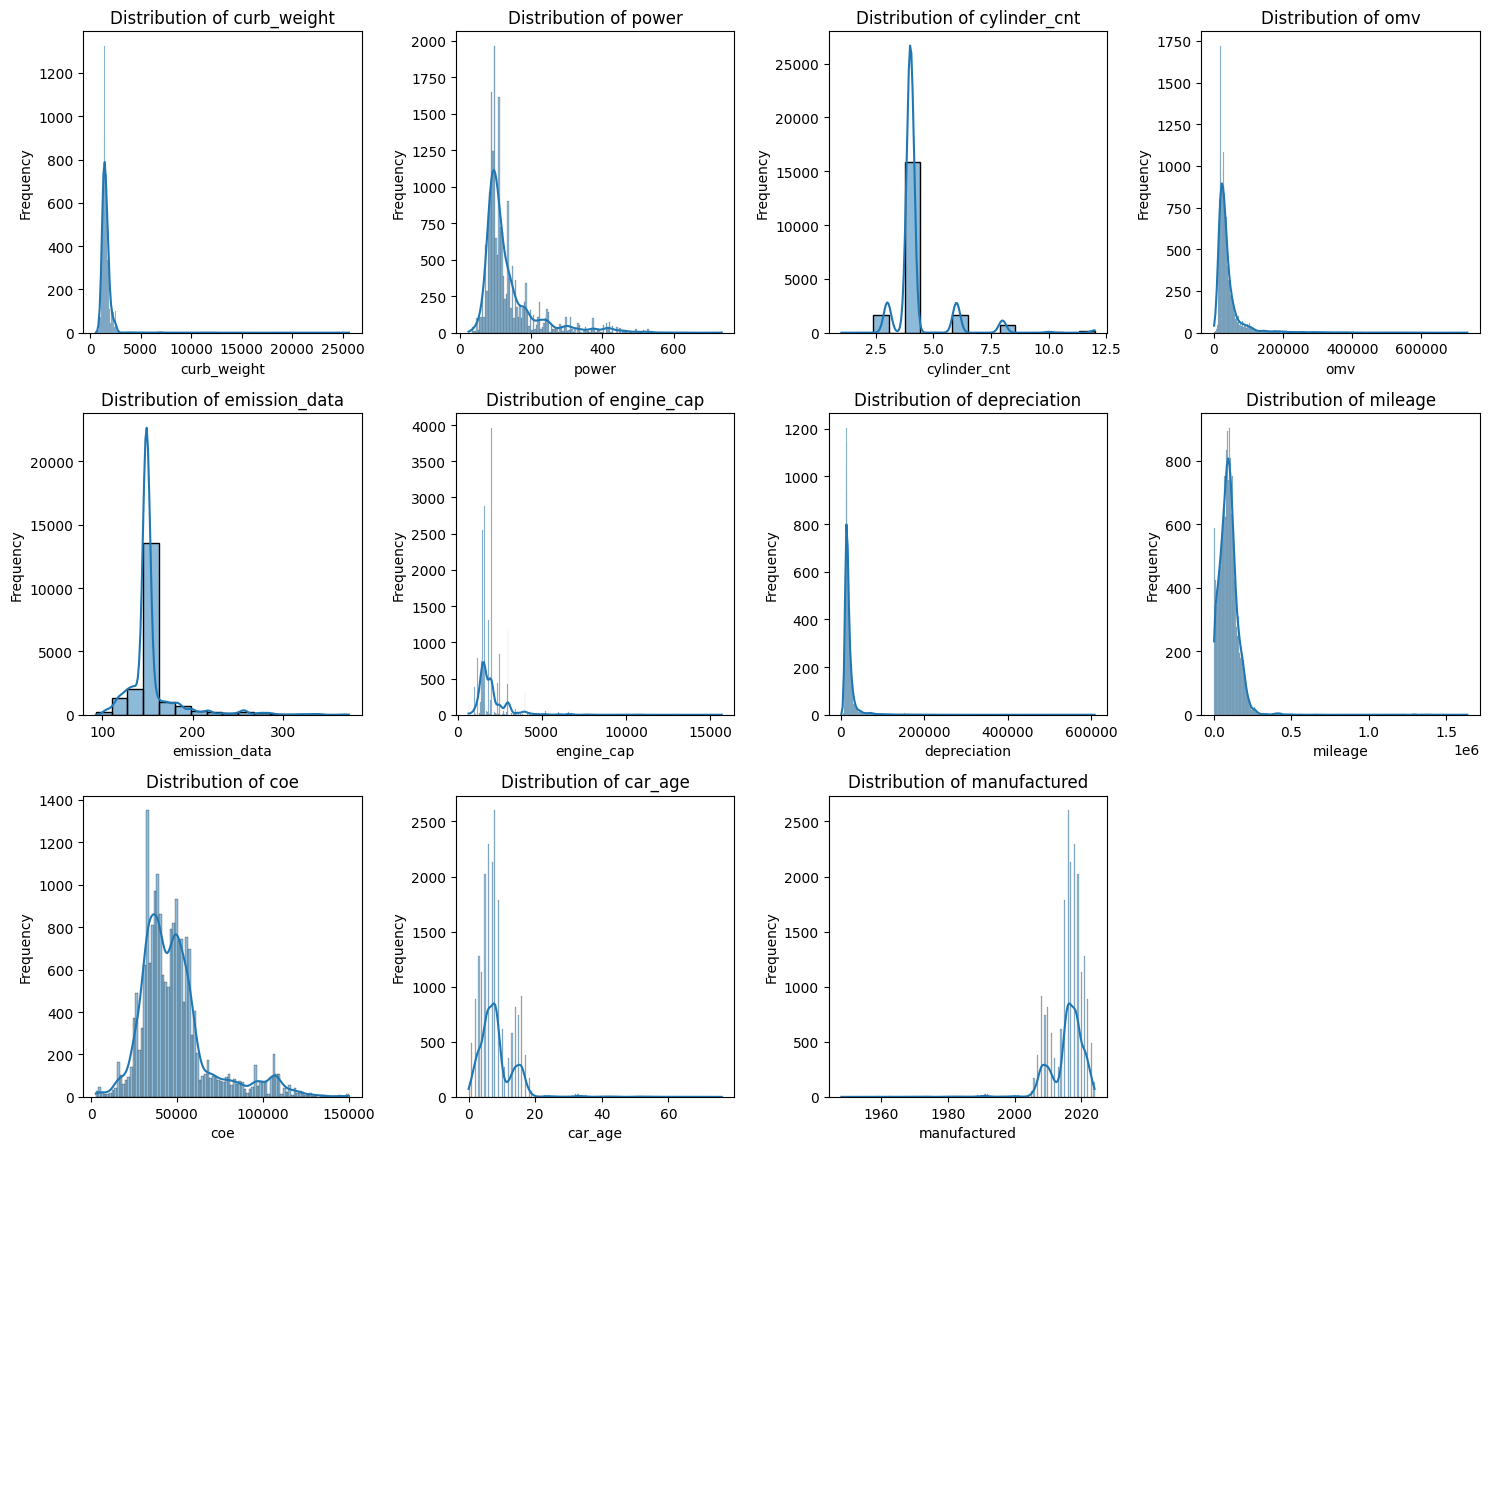

In [55]:
# Sanity Check
features = ['curb_weight', 'power', 'cylinder_cnt', 'omv', 'emission_data' ,\
'engine_cap', 'depreciation', 'mileage', 'coe', 'car_age', 'manufactured']

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Iterate over the numeric columns and create distribution plots
for i, column in enumerate(features):
    sns.histplot(data=train_df, x=column, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {column}', fontsize=12)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(len(features), len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Optional Save Checkpoint 2

In [56]:
name="w_outlier_simple_impute_no_FT_no_cond"
## Saving dataset
train_df.to_csv(f"./processed_dataset/train_{name}.csv", index=False)
val_df.to_csv(f"./processed_dataset/val_{name}.csv", index=False)
test_df.to_csv(f"./processed_dataset/test_{name}.csv", index=False)

In [ ]:
num_cols = 5  # Number of columns for subplots
features = ['curb_weight', 'power', 'cylinder_cnt', 'omv', 'engine_cap', 'depreciation', 'mileage', 'no_of_owners', 'coe', 'car_age', 'manufactured']

for feature in features:
    transformations = {}
    transformations.update(apply_transformations(train_df[feature]))
    
    # Prepare plots
    fig, axes = plt.subplots(1, num_cols, figsize=(20, 5), constrained_layout=True)
    fig.suptitle(f'Transformation Comparison for Feature: {feature}', fontsize=16)

    for idx, (transform_name, transformed_values) in enumerate(transformations.items()):
        ax = axes[idx]
        if transformed_values is not None:
            plot_data = pd.DataFrame({
                feature: transformed_values
            })
            
            ax = axes[idx]
            sns.histplot(data=plot_data, x=feature, bins=30, kde=True,
                         element='step', ax=ax, alpha=0.7)
            # Calculate skewness
            skew_val = skew(transformed_values)
            ax.set_title(f'{transform_name}\nSkew: {skew_val:.2f}', fontsize=12)
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')
        else:
            ax.set_visible(False)
            ax.set_title(f'{transform_name} (Not Applicable)', fontsize=12)

    plt.show()

# Superceeded

## All KNN imputers are put at the back

### ARF

In [ ]:
# Select features relevant for imputation
features = ['manufactured', 'reg_date_year', 'omv', 'arf', 'type_of_vehicle_bus/mini bus', 'type_of_vehicle_hatchback',
       'type_of_vehicle_luxury sedan', 'type_of_vehicle_mid-sized sedan',
       'type_of_vehicle_mpv', 'type_of_vehicle_others',
       'type_of_vehicle_sports car', 'type_of_vehicle_stationwagon',
       'type_of_vehicle_suv', 'type_of_vehicle_truck', 'type_of_vehicle_van']

display(f' Before imputation : {train_df["arf"].isna().sum()}')
arf_knn_imputer = GenericKNNImputer(feature=features, neighbours=5, imputed_feature="arf")

train_df['arf'] = arf_knn_imputer.fit_transform(train_df)
val_df['arf'] = arf_knn_imputer.transform(val_df)
test_df['arf'] = arf_knn_imputer.transform(test_df)

display(f' After imputation : {train_df["arf"].isna().sum()}')

### Dereg Value

In [ ]:
# Select features relevant for imputation
features = ['coe_age_left', 'coe', 'dereg_value']

display(f' Before imputation : {train_df["dereg_value"].isna().sum()}')
dereg_value_knn_imputer = GenericKNNImputer(feature=features, neighbours=5, imputed_feature="dereg_value")

train_df['dereg_value'] = dereg_value_knn_imputer.fit_transform(train_df)
val_df['dereg_value'] = dereg_value_knn_imputer.transform(val_df)
test_df['dereg_value'] = dereg_value_knn_imputer.transform(test_df)

display(f' After imputation : {train_df["dereg_value"].isna().sum()}')

### Road Tax

In [ ]:
features = ['manufactured',"power", "car_age","engine_cap",'reg_date_year', 'omv', 'arf', "road_tax",
'type_of_vehicle_bus/mini bus', 'type_of_vehicle_hatchback', 'type_of_vehicle_luxury sedan',
 'type_of_vehicle_mid-sized sedan','type_of_vehicle_mpv', 
       'type_of_vehicle_sports car', 'type_of_vehicle_stationwagon',
       'type_of_vehicle_suv', 'type_of_vehicle_truck', 'type_of_vehicle_van']

display(f' Before imputation : {train_df["road_tax"].isna().sum()}')
road_tax_knn_imputer = GenericKNNImputer(feature=features, neighbours=5, imputed_feature="road_tax")

train_df['road_tax'] = road_tax_knn_imputer.fit_transform(train_df)
val_df['road_tax'] = road_tax_knn_imputer.transform(val_df)
test_df['road_tax'] = road_tax_knn_imputer.transform(test_df)

display(f' After imputation : {train_df["road_tax"].isna().sum()}')

In [ ]:
## Saving dataset
train_df.to_csv("./dataset/train_data_cleaned.csv", index=False)
val_df.to_csv("./dataset/val_data_cleaned.csv", index=False)
test_df.to_csv("./dataset/test_data_cleaned.csv", index=False)

### features 

## Training models

In [ ]:
train_df.columns

In [ ]:
# display(HTML(train_df.head(50).to_html()))
# 'dereg_value', 'car_age', 'depreciation', 'arf','coe', 'road_tax',
features = ['transmission', 'curb_weight', 'power', 'engine_cap','no_of_owners', 'depreciation',
 'coe', 'road_tax', 'dereg_value','mileage', 'omv', 'arf','car_age', 'type_of_vehicle_bus/mini bus',
       'type_of_vehicle_hatchback', 'type_of_vehicle_luxury sedan',
       'type_of_vehicle_mid-sized sedan', 'type_of_vehicle_mpv',
       'type_of_vehicle_others', 'type_of_vehicle_sports car',
       'type_of_vehicle_stationwagon', 'type_of_vehicle_suv',
       'type_of_vehicle_truck', 'type_of_vehicle_van','coe car', 'parf car', 'rare & exotic', 'emission_data']

train_df[features].isna().sum()

In [ ]:
# Scale dataset
scaler = MinMaxScaler()
imputer = SimpleImputer(strategy='median')

imputer.fit(train_df[features])

# Split data into training and test sets
train_df[features] = imputer.transform(train_df[features])
val_df[features] = imputer.transform(val_df[features])
test_df[features] = imputer.transform(test_df[features])

# Fit and transform the numerical columns
train_df[features] = scaler.fit_transform(train_df[features])
val_df[features] = scaler.transform(val_df[features])
test_df[features] = scaler.transform(test_df[features])

In [ ]:
X_train = train_df[features]
y_train = train_df['price']

X_val = val_df[features]
y_val = val_df['price']

In [ ]:
# 2. Initialize the Regression class
regressor = Regression()

# 3. Define parameters for hyperparameter tuning
params = {
    'n_estimators': np.arange(200,500,50),
    'max_depth': np.arange(2,10,2),
    'min_samples_split': np.arange(10 ,60,10),
}


# Example for Random Forest with accuracy scoring and KFold validation
tuner, best_params, tuner_results = regressor.hyperparameter_tuning(
    df_tuple=(X_train, y_train),   # The training data (X, y)
    score_metric='neg_root_mean_squared_error',       # Scoring metric
    kfold_type='kfold',            # Type of fold (KFold used here)
    n_splits=5,                    # Number of splits for KFold
    params=params,                 # Hyperparameter grid to search
    model_name='random_forest'      # Model to use (Random Forest in this case)
)

# 4. View the best hyperparameters and fit the model
print(f"Best Parameters: {best_params}")

# 5. Use the best model to predict on the test set
best_model = tuner.best_estimator_


In [ ]:
# Save model 
model_name = "random_forest_with_all_imputes"
save_path = f"./model_assets"

# Save the trained model
joblib.dump(best_model, f"{save_path}/{model_name}.joblib")

In [ ]:
model_name = "random_forest_with_all_imputes"
save_path = f"./model_assets"

model = joblib.load(f"{save_path}/{model_name}.joblib")
reg_evaluate = RegressionEvaluate(model_weight_path= save_path)
reg_evaluate.mini_reg_evaluate(df_train_tuple=(X_train, y_train),
                            df_valid_tuple=( X_val,y_val),model_name=model_name, save_path=save_path)

In [ ]:
model_name = "random_forest_v4"
save_path = f"./model_assets"

reg_evaluate = RegressionEvaluate(model_weight_path= save_path)
reg_evaluate._plot_feature_immportance(model_name, features)

In [ ]:
model_name = "random_forest_v3"
save_path = f"./model_assets"

reg_evaluate.mini_reg_evaluate(df_train_tuple=(X_train, y_train),
df_valid_tuple=( X_val,y_val),model_name=model_name, save_path=save_path)

In [ ]:
## Retrain the model
# Train + Valid (Retrain on the whole model)
# best params
# all data

all_x = pd.concat([train_df[features],val_df[features]])
all_y = pd.concat([train_df["price"],val_df["price"]])
final_model = tuner.fit(X_train, y_train)


In [ ]:
final_model.best_estimator_

In [ ]:
model = joblib.load(f"{save_path}/{model_name}.joblib")
X_test = _infer_type(test_df[features])
y_test_pred = final_model.predict(X_test)
submission = pd.DataFrame(y_test_pred).reset_index().rename(columns={"index":"Id", 0:"Predicted"})
submission.to_csv(f"submission/submission_{model_name}_.csv")